# PBMC datasets - vary size of query dataset for simulations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import scipy
import anndata

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import q2r_uncertainty
import diff2atlas


Global seed set to 0
/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


ModuleNotFoundError: No module named 'q2r_uncertainty'

In [ ]:
import celltypist
import milopy

In [ ]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import anndata2ri
anndata2ri.activate()

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(tidyverse)
library(patchwork)

In [ ]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

### Split query batch with variable no of cells

In [98]:
query_dataset = '10_1038_s41591_021_01329_2'

In [6]:
adata_1k = sc.read_h5ad('/home/jupyter/mount/gdrive/query2reference/PBMC_CZIintegration_data/10_1038_s41591_021_01329_2.normal.subsample1000cells.h5ad', backed=False)

### Cleaning and Quality filtering

In [11]:
sc.pp.calculate_qc_metrics(adata_1k, inplace=True)

In [12]:
adata_1k = adata_1k[adata_1k.obs['total_counts'] > 1000].copy()
sc.pp.filter_genes(adata_1k, min_cells=1)

In [13]:
## Make version with fixed cell type names 
def clean_pop_name(string):
    clean = ''.join(e if e.isalnum() else '_' for e in string)
    return('_'.join(clean.split('__')))

adata_1k.obs['cell_type'] = [clean_pop_name(x) for x in adata_1k.obs['cell_type']]

### Map to model trained on 500 cells per sample

Built in [here](https://github.com/emdann/query2reference_uncertainty/blob/master/notebooks/PBMC_metanalysis/20220531_PBMC_metadata.ipynb)

In [25]:
data_dir = '/home/jupyter/mount/gdrive/diff2atlas/scratch117_copy/'
model_path = data_dir + 'model_atlas'
# adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.scVI.h5ad')

In [26]:
from oor_benchmark.methods._latent_embedding import _fit_scVI

In [27]:
vae_ref = scvi.model.SCVI.load(model_path)

INFO     File /home/jupyter/mount/gdrive/diff2atlas/scratch117_copy/model_atlas/model.pt     
         already downloaded                                                                  


In [ ]:
adata_1k.layers['counts'] = adata_1k.X.copy()
scvi.model.SCVI.prepare_query_anndata(adata_1k, model_path)

In [48]:
vae_q = _fit_scVI(vae_ref, adata_1k, train_params={'max_epochs':200})

/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=200 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [28:41<00:00,  8.39s/it, loss=1.21e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [28:41<00:00,  8.61s/it, loss=1.21e+03, v_num=1]


In [58]:
vae_q.save(data_dir + 'model_subsample1000_query', save_anndata=True)

In [55]:
adata_1k.obsm['X_scVI'] = vae_q.get_latent_representation()

### Concatenate with atlas data

Reload to have full gene list

In [63]:
adata_atlas = sc.read_h5ad('/home/jupyter/mount/gdrive/query2reference/PBMC_CZIintegration_data/PBMC_merged.normal.subsample500cells.h5ad')

In [60]:
adata_query =  sc.read_h5ad('/home/jupyter/mount/gdrive/query2reference/PBMC_CZIintegration_data/10_1038_s41591_021_01329_2.normal.subsample1000cells.h5ad', backed=False)

In [74]:
adata_query = adata_query[adata_query.obs_names.isin(adata_1k.obs_names)].copy()

In [75]:
adata_atlas = adata_atlas[vae_ref.adata.obs_names].copy()

In [76]:
adata_atlas.obsm['X_scVI'] = vae_ref.get_latent_representation()
adata_query.obsm['X_scVI'] = vae_q.get_latent_representation()

In [77]:
adata = adata_atlas.concatenate(adata_query)

/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [81]:
adata.obs = adata.obs.drop("batch", 1)

/tmp/ipykernel_28772/68398810.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  adata.obs = adata.obs.drop("batch", 1)


In [83]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_scVI', key_added='scVI')
sc.tl.umap(adata, neighbors_key='scVI')

IOStream.flush timed out
IOStream.flush timed out


## Cluster

In [84]:
%%time
sc.tl.leiden(adata, resolution=1.5, neighbors_key='scVI', n_iterations=5)

CPU times: user 5min 27s, sys: 7.17 s, total: 5min 34s
Wall time: 5min 33s


In [ ]:
adata.write_h5ad(data_dir + 'PBMC_merged.normal.subsample1000cells.scVI.h5ad')

In [90]:
os.path.exists(data_dir + 'PBMC_merged.normal.subsample1000cells.scVI.h5ad')

True

In [ ]:
# adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.scVI.h5ad', backed=True)

/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


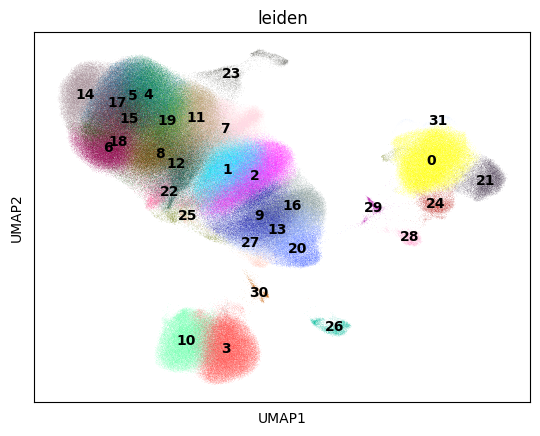

In [91]:
sc.pl.umap(adata, color='leiden', legend_loc='on data')

/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


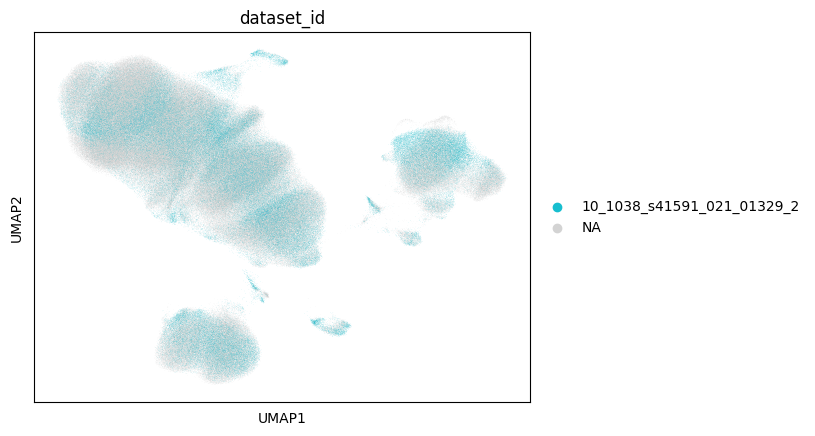

In [99]:
sc.pl.umap(adata, color='dataset_id', groups=[query_dataset])

In [100]:
conf_mat = sc.metrics.confusion_matrix('leiden', 'cell_type', adata.obs)

In [101]:
cell_type_leiden = dict(zip(conf_mat.index, conf_mat.idxmax(1)))
cell_type_leiden_frac = dict(zip(conf_mat.index, conf_mat.max(1)))

adata.obs['cell_type_leiden'] = [cell_type_leiden[x] for x in adata.obs['leiden']]
adata.obs['cell_type_leiden_frac'] = [cell_type_leiden_frac[x] for x in adata.obs['leiden']]

/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


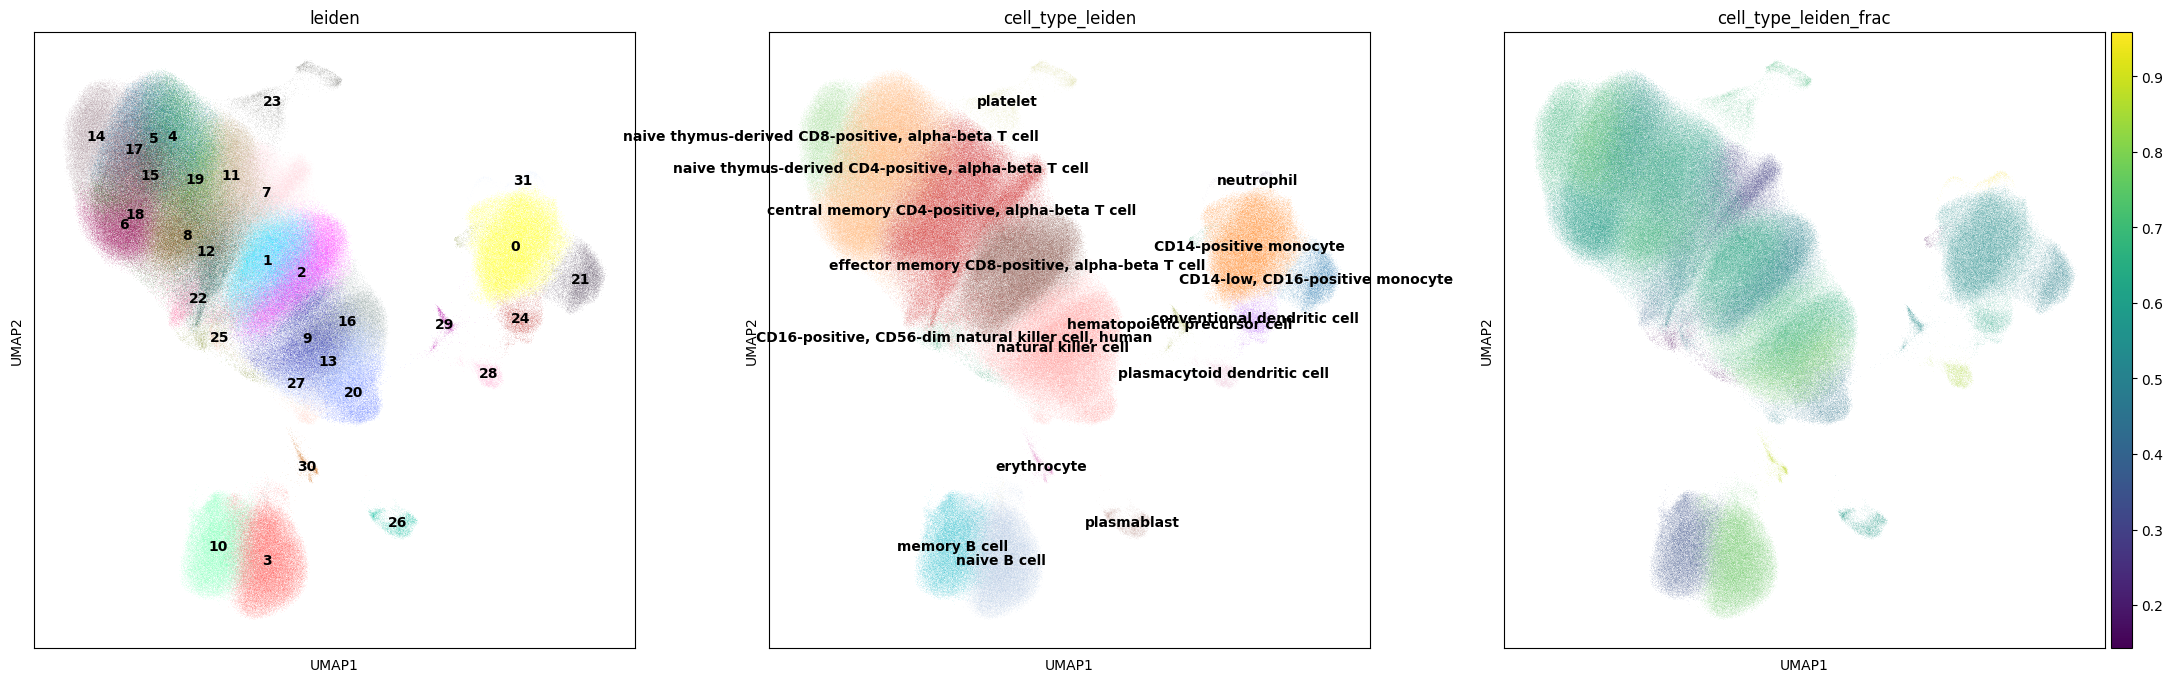

In [102]:
with rc_context({'figure.figsize':[8,8]}):
    sc.pl.umap(adata, color=['leiden', 'cell_type_leiden', 'cell_type_leiden_frac'], legend_loc='on data')

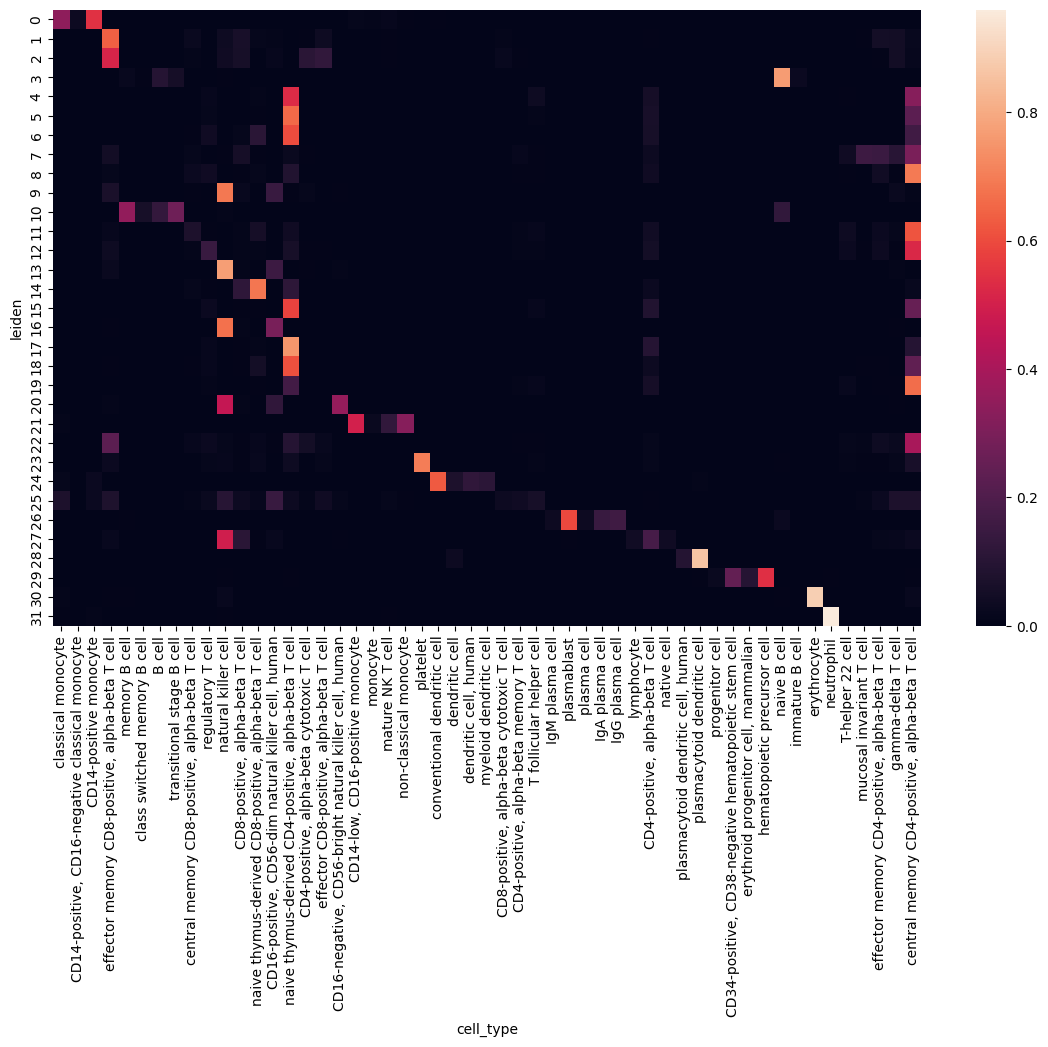

In [103]:
conf_mat_plt = conf_mat.loc[:,conf_mat.max() > 0.025]
col_order = conf_mat_plt.idxmax(0).sort_values().index
with rc_context({'figure.figsize':[14,8]}):
    sns.heatmap(conf_mat_plt.loc[:,col_order])

In [106]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

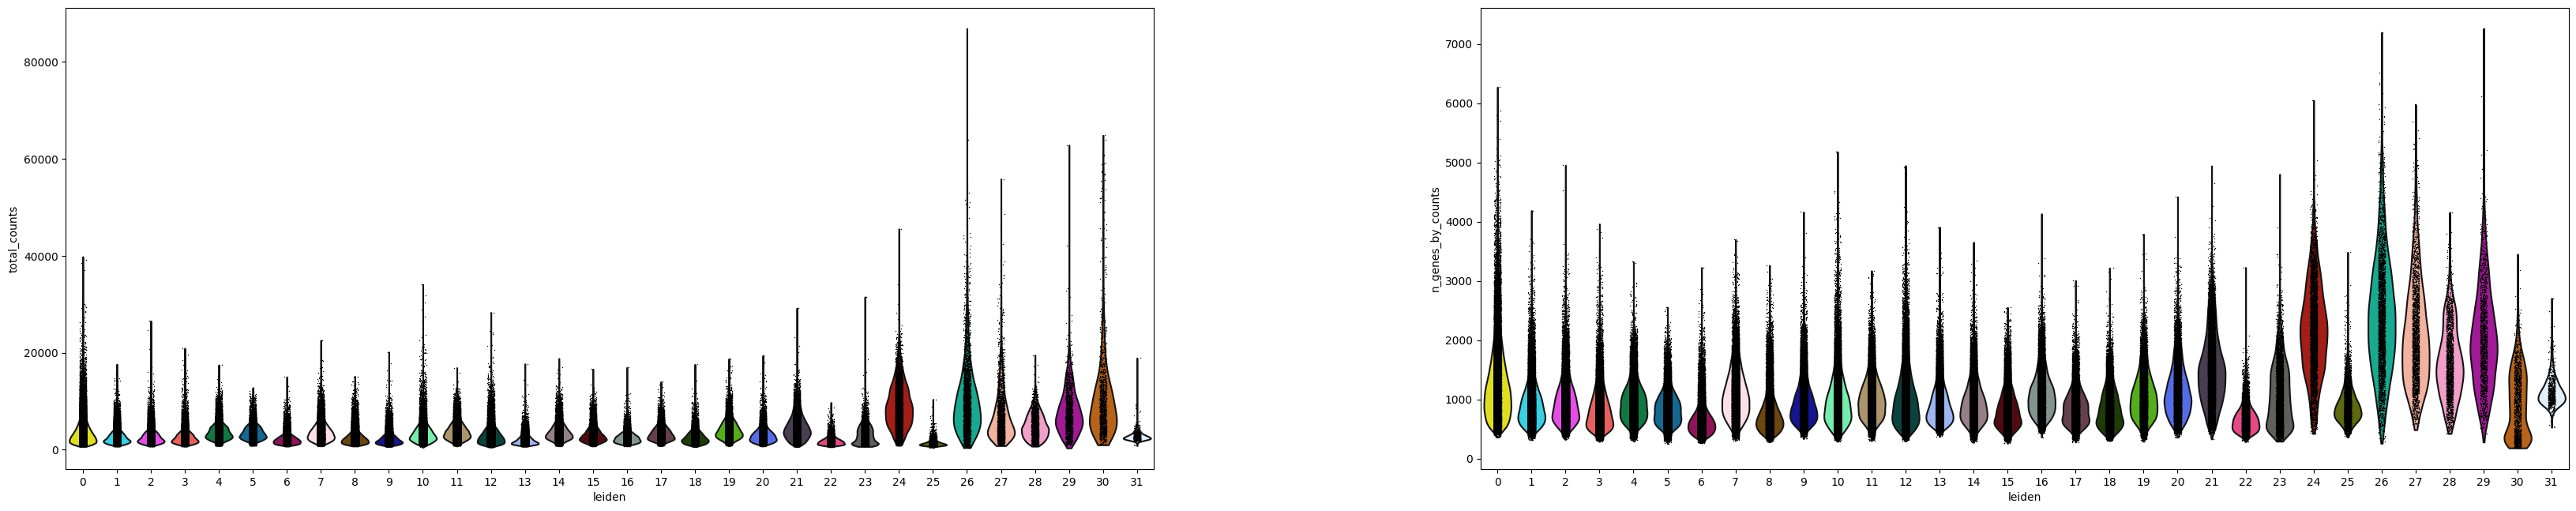

In [107]:
with rc_context({'figure.figsize':[14,8]}):
    sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts'],groupby='leiden')

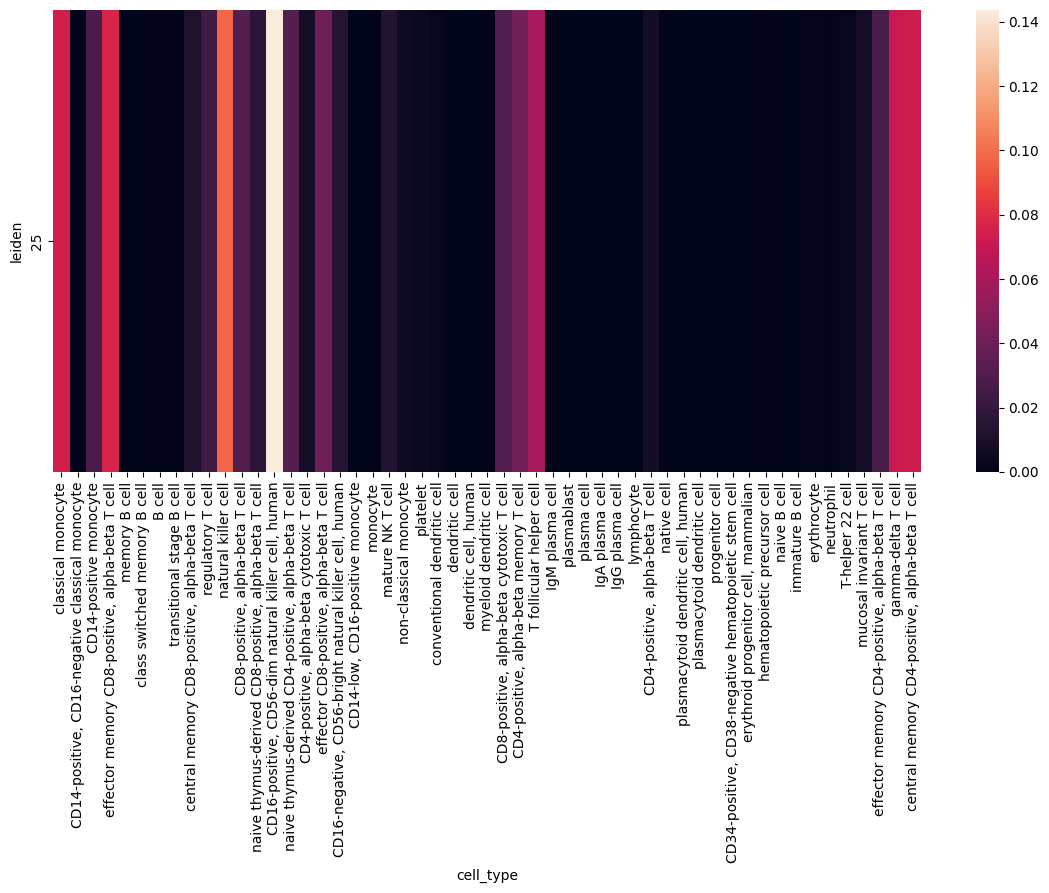

In [121]:
low_q = ['25']
with rc_context({'figure.figsize':[14,6]}):
    sns.heatmap(conf_mat_plt.loc[low_q,col_order])

/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


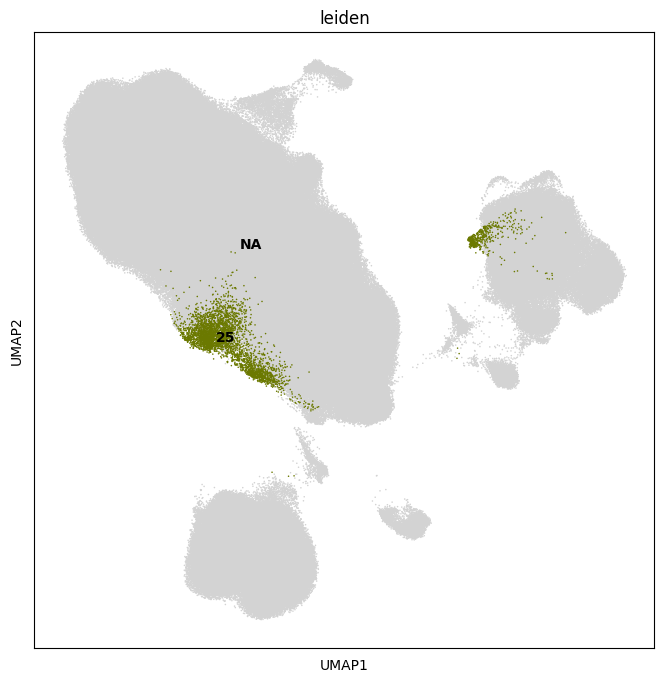

In [122]:
with rc_context({'figure.figsize':[8,8]}):
    sc.pl.umap(adata, color=['leiden'], legend_loc='on data', groups=low_q, size=5)

In [123]:
## Remove low-quality (potentially doublet) cluster
adata = adata[~adata.obs['leiden'].isin(low_q)].copy()

In [124]:
## Make version with fixed names for submitting jobs 
def clean_pop_name(string):
    clean = ''.join(e if e.isalnum() else '_' for e in string)
    return('_'.join(clean.split('__')))

adata.obs['cell_type'] = [clean_pop_name(x) for x in adata.obs['cell_type_leiden']]

In [125]:
adata[adata.obs['dataset_id'] == query_dataset].obs['cell_type'].value_counts()

central_memory_CD4_positive_alpha_beta_T_cell          22108
natural_killer_cell                                    20525
naive_thymus_derived_CD4_positive_alpha_beta_T_cell    20334
CD14_positive_monocyte                                 17528
effector_memory_CD8_positive_alpha_beta_T_cell         15149
naive_B_cell                                           10776
memory_B_cell                                           6211
naive_thymus_derived_CD8_positive_alpha_beta_T_cell     4326
platelet                                                3478
plasmablast                                             1769
CD14_low_CD16_positive_monocyte                         1676
conventional_dendritic_cell                             1309
plasmacytoid_dendritic_cell                              705
erythrocyte                                              654
hematopoietic_precursor_cell                             581
neutrophil                                                 7
Name: cell_type, dtype: 

### Save for jobs

In [129]:
# outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
outdir = data_dir
adata.write_h5ad(outdir + 'PBMC_merged.normal.subsample1000cells.clean_celltypes.h5ad')
outdir + 'PBMC_merged.normal.subsample1000cells.clean_celltypes.h5ad'

'/home/jupyter/mount/gdrive/diff2atlas/scratch117_copy/PBMC_merged.normal.subsample1000cells.clean_celltypes.h5ad'

In [130]:
## Save list of celltypes
with open(outdir + 'PBMC_merged.normal.subsample1000cells.clean_celltypes.txt', 'w') as f:
    for line in adata.obs['cell_type'].unique().tolist():
        f.write("%s\n" % line)

---